# Importando bibliotecas

In [31]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sys import stdout
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [32]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d')

data = pd.read_csv('data/transformed/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data.head()

,value,date
index,,
2000-01-01,6205.0,2000-01-01
2000-01-02,6797.0,2000-01-02
2000-01-03,7024.0,2000-01-03
2000-01-04,6921.0,2000-01-04
2000-01-05,7025.0,2000-01-05


# 2. SARIMA

## 2.1 Tratando os dados internos

In [33]:
split_date = '1/1/2020 12:00:00 AM'
test  = data[split_date : ]
train = data[ : split_date]

train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)

series

index
2000-01-01     6205.000
2000-01-02     6797.000
2000-01-03     7024.000
2000-01-04     6921.000
2000-01-05     7025.000
                ...    
2021-01-27    12308.892
2021-01-28    12550.095
2021-01-29    12413.574
2021-01-30    11988.032
2021-01-31    11540.266
Name: value, Length: 7702, dtype: float64

## 2.2 Métodos para treinamento

In [34]:
# Mostrar previsão de acordo com os dados originais
def plot_forecasts(series, forecasts, test):
	plt.plot(series) # blue

	# Colocando no gráfico as previsões com a cor vermelha
	for i in range(len(forecasts)):
        # Inicio e fim dos dos deslocamentos por x
		off_s = len(series) - len(test) + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]

        # Valores dos multiplos passos de previsão
		yaxis = [series[off_s]] + forecasts[i]
		plt.plot(xaxis, yaxis, color='red')

	# Gráfico
	plt.show()

# Avaliação de erro do SARIMA
def evaluate_forecasts(test, forecasts, n_steps):
    sum_rmse = 0
    sum_mape = 0
    for i in range(n_steps):
        ypred_ts = [forecast[i] for forecast in forecasts]
        ytrue_ts = test[i:len(ypred_ts)+i]
        # Calculando os erros
        mape = mean_absolute_percentage_error(ytrue_ts, ypred_ts)*100
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}")

    # média dos erros
    print(f"Média do RMSE: {sum_rmse/n_steps}")
    print(f"Média do MAPE: {sum_mape/n_steps}")

# Treinamento de previsão por ARIMA por multiplos passos
def sarima_forecast(train, config, n_steps):
	order, s_order, trend = config
	# Definindo e moldando o modelo
	model = SARIMAX(train, order=order, seasonal_order=s_order, trend=trend, enforce_stationarity=False,
                            enforce_invertibility=False)
	model_fit = model.fit()

	# Fazendo previsão com multiplos passos
	yhat = model_fit.predict(len(train), len(train)+n_steps-1)
	yhat_list = [value for value in yhat]

	return yhat_list

## 2.3 Treinamento e resultado

	t=(390 de 391) -> Predito=11575.650562, Esperado=12271.288000Ultimos 10 valores:
Predito=[12058.810039635619, 12127.975741347384, 12216.157744910657, 12122.295596451537, 12066.207933451538, 12072.55452309382, 12014.02191889316], Esperado=12115.408
Predito=[12167.009393019627, 12253.48721210587, 12150.284636427894, 12087.152099665554, 12092.215511046654, 12030.480750327335, 12149.378178055364], Esperado=11904.916
Predito=[12040.173446602019, 11925.001855514558, 11872.57213469212, 11908.357945958296, 11847.461771522903, 11971.600478053855, 11930.282275018573], Esperado=12622.064
Predito=[12437.995082006035, 12435.963193276382, 12478.059502397091, 12392.12612844621, 12539.020182842523, 12512.624996305649, 12516.37866399441], Esperado=12365.629
Predito=[12390.16984643786, 12438.917907966063, 12369.801269562646, 12538.28138262699, 12523.774034341028, 12538.275638700388, 12465.226666825896], Esperado=12258.734
Predito=[12317.320569246436, 12226.050736388928, 12385.810797233386, 12369.658164

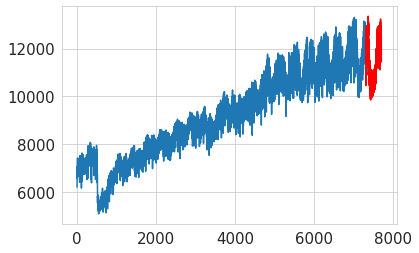

In [35]:
test = test.values
series = series.values
train = [x for x in train]

n_steps = 7

# Ordem de tendencial
p_param = 1
d_param = 1
q_param = 1
# Periodo e ordem sazonal
P_param = 2
D_param = 1
Q_param = 2
m_param = 4
# Tipo de tendencia
t_params = 'ct'  # outros tipos: 'n','c','t','ct'
# configuração
config = [(p_param,d_param,q_param), (P_param,D_param,Q_param,m_param), t_params]

# lista para armazenar os paços de predição e a quantidade de predições a frente
forecasts = list()
forecasts_exp = list()
n_forecasts = len(test) - n_steps + 1

for i in range(n_forecasts):
    # prevendo valor por sarima
    yhat = sarima_forecast(train, config, n_steps)
    # adicionando valor de predição a lista
    forecasts.append(yhat)
    # Adicionando valor de previsão pelo treino para o proximo loop
    obs = test[i]
    train.append(obs)
    forecasts_exp.append([yhat, obs])
    stdout.write("\r\tt=(%i de %i) -> Predito=%f, Esperado=%f" % (i, n_forecasts, yhat[0], obs))

print("Ultimos 10 valores:")
for item in forecasts_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

# Avaliação da previsão
evaluate_forecasts(test, forecasts, n_steps)
# Mostrar previsão
plot_forecasts(series, forecasts, test)